In [ ]:
# based on tutorial from https://medium.com/analytics-vidhya/object-localization-using-keras-d78d6810d0be
# and https://towardsdatascience.com/evolution-of-object-detection-and-localization-algorithms-e241021d8bad

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import matplotlib.animation as animation

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')

In [ ]:
image_shape = (128, 128, 3)
number_of_object_classes = 1
yolo_grid_amount_one_direction = 8
yolo_grid_side_length = int(image_shape[0]/yolo_grid_amount_one_direction)
number_of_bounding_boxes_per_grid = 2
yolo_grid_side_length

16

In [ ]:

@tf.function()
def yolo_loss(y_true, y_pred):

    lambda_coord = 5.0
    lambda_noobj = 0.5


    localization_of_center_1 = tf.reduce_sum((y_true[:,:, 1] - y_pred[:, :, 1]) ** 2.0 + (y_true[:,:, 2] - y_pred[:, :, 2]) ** 2.0 ,axis=-1)
    localization_of_center_2 = tf.reduce_sum(((y_true[:,:, 1+5] - y_pred[:, :, 1+5]) ** 2.0 + (y_true[:,:, 2+5] - y_pred[:, :, 2+5]) ** 2.0), axis=-1)
    localization_of_center = localization_of_center_1 + localization_of_center_2
    localization_of_center *= lambda_coord


    # size_1 = tf.reduce_sum((tf.sqrt(y_true[:,:, 3]) - tf.sqrt(y_pred[:, :, 3])) ** 2.0 + (tf.sqrt(y_true[:,:, 4]) - tf.sqrt(y_pred[:, :, 4])) ** 2.0  ,axis=-1)
    # size_2 = tf.reduce_sum((tf.sqrt(y_true[:,:, 3+5]) - tf.sqrt(y_pred[:, :, 3+5])) ** 2.0  + (tf.sqrt(y_true[:,:, 4+5]) - tf.sqrt(y_pred[:, :, 4+5])) ** 2.0 , axis=-1)

    # print(size_1)


    size_1 = tf.reduce_sum((y_true[:,:, 3] - y_pred[:, :, 3]) ** 2.0 + (y_true[:,:, 4] - y_pred[:, :, 4]) ** 2.0  ,axis=-1)
    size_2 = tf.reduce_sum((y_true[:,:, 3+5] - y_pred[:, :, 3+5]) ** 2.0  + (y_true[:,:, 4+5] - y_pred[:, :, 4+5]) ** 2.0 , axis=-1)

    size = size_1 + size_2
    size *= lambda_coord

    has_obj_1 = tf.reduce_sum(y_true[:,:, 0] * (y_true[:,:, 0] - y_pred[:, :, 0]) ** 2.0 ,axis=-1)
    has_obj_2 = tf.reduce_sum(y_true[:,:, 0] * (y_true[:,:, 0+5] - y_pred[:, :, 0+5]) ** 2.0 ,axis=-1)
    has_obj = has_obj_1 + has_obj_2

    no_obj_1 = tf.reduce_sum((1-y_true[:,:, 0]) * (y_true[:,:, 0] - y_pred[:, :, 0]) ** 2.0 ,axis=-1)
    no_obj_2 = tf.reduce_sum((1-y_true[:,:, 0]) * (y_true[:,:, 0+5] - y_pred[:, :, 0+5]) ** 2.0 ,axis=-1)
    no_obj = no_obj_1 + no_obj_2
    no_obj *= lambda_noobj

    class1 = tf.reduce_sum((y_true[:,:, 10] - y_pred[:, :, 10]) ** 2.0 ,axis=-1)

    return localization_of_center + has_obj + no_obj + class1 + size
    # return has_obj






In [ ]:
def create_model1():
    vgg16 = tf.keras.applications.VGG16(input_shape=image_shape, include_top=False, weights='imagenet')
    flatten = tf.keras.layers.Flatten()(vgg16.output)
    # reshape = tf.keras.layers.Reshape((yolo_grid_amount_one_direction ** 2, (number_of_bounding_boxes_per_grid * 5 + number_of_object_classes)))(flatten)
    # conv0 = tf.keras.layers.Conv2D(4)(flatten)

    # grid_cells = [tf.keras.layers.Dense(number_of_bounding_boxes_per_grid * 5 + number_of_object_classes, activation='softmax')(flatten) for _ in range(yolo_grid_amount_one_direction ** 2)]
    # concatinate = tf.keras.layers.Concatenate()(grid_cells)
    dense0 = tf.keras.layers.Dense((yolo_grid_amount_one_direction ** 2) * (number_of_bounding_boxes_per_grid * 5 + number_of_object_classes), activation='sigmoid', kernel_initializer='zeros')(flatten)
    outputs = tf.keras.layers.Reshape((yolo_grid_amount_one_direction ** 2, number_of_bounding_boxes_per_grid * 5 + number_of_object_classes))(dense0)
    model = tf.keras.Model(vgg16.inputs,outputs)
    model.compile(loss=yolo_loss, optimizer=tf.keras.optimizers.SGD(lr=0.001), metrics=['acc'])
    return model

In [ ]:
model1 = create_model1()

In [ ]:
model1.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0  

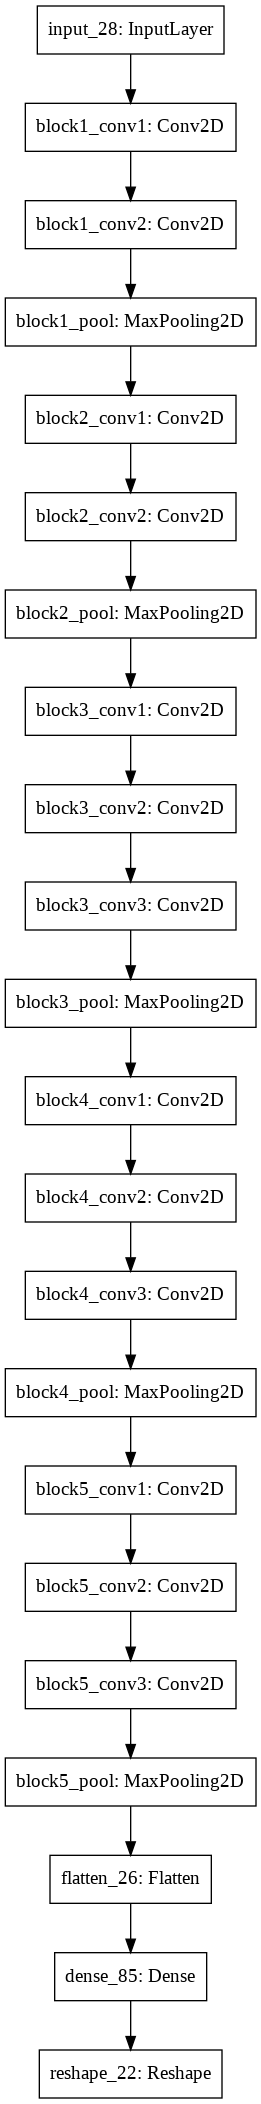

In [ ]:
tf.keras.utils.plot_model(model1)

In [ ]:
class SyntheticGen(tf.keras.utils.Sequence):

    def __init__(self, batch_size=64, max_radius=20, min_radius=5, max_objects=5):
        self.batch_size = batch_size
        self.max_radius = max_radius
        self.min_radius = min_radius
        self.max_objects = max_objects

    def __len__(self):
        return self.batch_size

    def __iter__(self):
        return self

    def __next__(self):
        inputs = np.zeros((self.batch_size, *image_shape), dtype='int32')
        outputs = np.zeros((self.batch_size, yolo_grid_amount_one_direction ** 2, number_of_bounding_boxes_per_grid * 5 + number_of_object_classes))
        for i in range(self.batch_size):
            num_objects = np.random.randint(1, self.max_objects)
            for j in range(num_objects):
                top_left_x = x_coord = np.random.randint(0, image_shape[0]-self.max_radius*2-1)
                top_left_y = np.random.randint(0, image_shape[1]-self.max_radius*2-1)
                radius = np.random.randint(self.min_radius, self.max_radius)
                center_x = top_left_x + radius
                center_y = top_left_y + radius
                bottom_right_x = center_x + radius
                bottom_right_y = center_y + radius
                # print(radius)
                max_x = top_left_x+radius*2
                max_y = top_left_y+radius*2
                for x in range(top_left_x, max_x):
                    for y in range(top_left_y, max_y):
                        if ((x - center_x) ** 2 + (y - center_y) ** 2) < radius ** 2:
                            # print(x, y)
                            inputs[i, x, y] = 1
                object_probability = 1
                object_center_x = center_x - (center_x // yolo_grid_side_length) * yolo_grid_side_length
                object_center_y = center_y - (center_y // yolo_grid_side_length) * yolo_grid_side_length
                object_width_as_percentage_of_cell_width = radius * 2 / yolo_grid_side_length
                object_height_as_percentage_of_cell_height = radius * 2 / yolo_grid_side_length
                grid_x = int(center_x // yolo_grid_side_length)
                grid_y = int(center_y // yolo_grid_side_length)
                grid_number = grid_x * yolo_grid_amount_one_direction + grid_y
                for k in range(0, 5 * number_of_bounding_boxes_per_grid, 5):
                    if outputs[i, grid_number, k] == 1:
                        continue
                    outputs[i, grid_number, k] = object_probability
                    outputs[i, grid_number, k+1] = object_center_x / yolo_grid_side_length
                    outputs[i, grid_number, k+2] = object_center_y / yolo_grid_side_length
                    outputs[i, grid_number, k+3] = object_width_as_percentage_of_cell_width / yolo_grid_amount_one_direction
                    outputs[i, grid_number, k+4] = object_height_as_percentage_of_cell_height / yolo_grid_amount_one_direction
                    break
                outputs[i, grid_number, 5 * number_of_bounding_boxes_per_grid + 0] = 1
                    

        # return inputs.astype('float32'), np.reshape(outputs, (outputs.shape[0], -1))
        return inputs.astype('float32'), outputs

    def __getitem__(self, _index):
        return next(self)

In [ ]:
sample_synthetic_inputs, sample_synthetic_outputs = next(SyntheticGen())
sample_synthetic_inputs.shape, sample_synthetic_outputs.shape

((64, 128, 128, 3), (64, 64, 11))

In [ ]:
sample_synthetic_outputs[0]

array([[0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.   

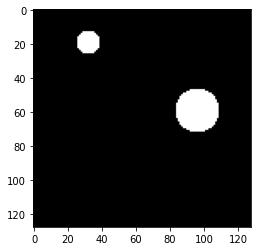

In [ ]:
plt.imshow(sample_synthetic_inputs[0])

In [ ]:
model1.fit(SyntheticGen(), epochs=50,)

Epoch 1/50
64/64 [==============================] - 14s 209ms/step - loss: 1.6405 - acc: 0.5371
Epoch 2/50
64/64 [==============================] - 13s 209ms/step - loss: 1.7001 - acc: 0.5381
Epoch 3/50
64/64 [==============================] - 13s 206ms/step - loss: 1.5761 - acc: 0.5348
Epoch 4/50
64/64 [==============================] - 13s 206ms/step - loss: 1.6482 - acc: 0.5272
Epoch 5/50
64/64 [==============================] - 13s 207ms/step - loss: 1.6350 - acc: 0.5309
Epoch 6/50
64/64 [==============================] - 13s 204ms/step - loss: 1.5440 - acc: 0.5298
Epoch 7/50
64/64 [==============================] - 13s 208ms/step - loss: 1.6255 - acc: 0.5311
Epoch 8/50
64/64 [==============================] - 13s 209ms/step - loss: 1.5918 - acc: 0.5407
Epoch 9/50
64/64 [==============================] - 13s 203ms/step - loss: 1.5896 - acc: 0.5394
Epoch 10/50
64/64 [==============================] - 13s 206ms/step - loss: 1.5377 - acc: 0.5291
Epoch 11/50
64/64 [====================

In [ ]:
model1.save('/content/drive/MyDrive/yolo/yolo0.h5')

In [ ]:
predictions = model1.predict(sample_synthetic_inputs)

In [ ]:
def plot_rect(image, prediction, ax=None):
    if ax == None:
        _, ax = plt.subplots(1)
    ax.imshow(image)
    # prediction = np.reshape(prediction, (-1,))
    for gridcell in range(0, prediction.shape[0]):
        for i in range(0, 5 * number_of_bounding_boxes_per_grid, 5):
            probability = prediction[gridcell, i]
            # print(probability)
            if probability > 0.5:
                width = prediction[gridcell, i+3] * yolo_grid_side_length *  yolo_grid_amount_one_direction
                height = prediction[gridcell, i+4] * yolo_grid_side_length *  yolo_grid_amount_one_direction

                box_x = gridcell % yolo_grid_amount_one_direction * yolo_grid_side_length
                box_y = gridcell // yolo_grid_amount_one_direction * yolo_grid_side_length

                x = prediction[gridcell,i+1] * yolo_grid_side_length + box_y - width / 2
                y = prediction[gridcell,i+2] * yolo_grid_side_length + box_x - width / 2
                # print(gridcell)
                # print(box_x, box_y)
                # print(x, y)

                # print(width, height)
                # print(prediction[box+i+3])
                # print(prediction[box+i+1], prediction[box+i+2])
                # point = patches.Rectangle((prediction[box+i+2] * image_shape[0]-2, prediction[box+i+1] * image_shape[0]-2), width=4, height=4, color='r')
                rect = patches.Rectangle((y, x), width, height, color='g', linewidth=3, fill=False)
                ax.add_patch(rect)
                # ax.add_patch(point)
        
    # plt.show()
    return ax

In [ ]:
def plot_rects(images, predictions):
    fig, ax = plt.subplots(1)
    i=0
    def frame_func(i):
        ax.clear()
        return plot_rect(images[i], predictions[i], ax)
        

    # plt.show()
    return animation.FuncAnimation(fig, frame_func, frames=len(images), repeat=True, interval=500)

In [ ]:
predictions[0]

array([[3.99952382e-03, 7.45234545e-04, 1.98939536e-03, 1.51388731e-03,
        1.51388731e-03, 2.64369999e-03, 7.40182470e-04, 7.42590229e-04,
        7.25213322e-04, 7.25213322e-04, 2.55144876e-03],
       [1.07078278e-03, 3.81013582e-04, 1.22103945e-03, 1.31378509e-03,
        1.31378509e-03, 2.74378574e-03, 7.87140685e-04, 7.59683317e-04,
        7.32026761e-04, 7.32026761e-04, 6.17332116e-04],
       [8.45529977e-03, 3.17410845e-03, 1.39910658e-03, 2.93273828e-03,
        2.93273828e-03, 2.91683013e-03, 8.45729955e-04, 7.89419748e-04,
        7.40123214e-04, 7.40123214e-04, 4.88416804e-03],
       [1.66447333e-03, 8.24036018e-04, 9.09604016e-04, 1.48590351e-03,
        1.48590351e-03, 2.81412713e-03, 8.01739807e-04, 7.74905668e-04,
        7.34950241e-04, 7.34950241e-04, 1.10017916e-03],
       [1.77786418e-03, 1.30425324e-03, 7.44181743e-04, 1.06429530e-03,
        1.06429530e-03, 2.70132767e-03, 7.71036721e-04, 7.51686573e-04,
        7.29890307e-04, 7.29890307e-04, 1.24932616e-

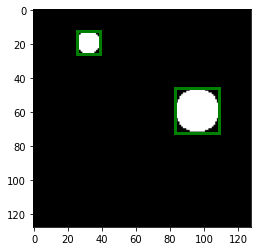

In [ ]:

plot_rect(sample_synthetic_inputs[0], sample_synthetic_outputs[0])

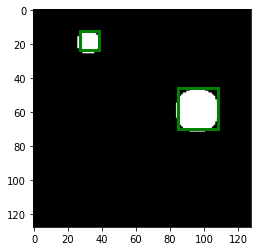

In [ ]:
plot_rect(sample_synthetic_inputs[0], predictions[0])

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

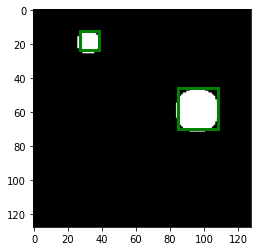

In [ ]:
animation1 = plot_rects(sample_synthetic_inputs, predictions)
animation1

In [ ]:
animation1.save('/content/drive/MyDrive/yolo/sample.mp4')

In [ ]:
# !cp '/content/drive/MyDrive/data/faces.zip' '/content'
# !unzip /content/faces.zip